# Toxic Comment Classification Challenge
- 6 classes of toxic
- Create a prediction model which predict probs of toxicity for each comment


# 0. Check Version

## Package Version and datetime last run

In [1]:
# !pip install tensorflow==2.14.0
# !pip install tensorflow_hub==0.15.0

In [2]:
import datetime
print(f'Datetime last run (end-to-end): {datetime.datetime.now()}')

import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

Datetime last run (end-to-end): 2024-09-12 12:08:38.741579
2.14.0
0.15.0


## Import Helper Functions and Dataset
- Dataset imported from local disk

In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, calculate_results, compare_baseline_to_new_results

SAVE_DIR = 'model_logs'

# 1. Visualize Txt Data

## 1.1 DataFrame

In [4]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head(), test_df.head()

(                 id                                       comment_text  toxic  \
 0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
 1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
 2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
 3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
 4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
 
    severe_toxic  obscene  threat  insult  identity_hate  
 0             0        0       0       0              0  
 1             0        0       0       0              0  
 2             0        0       0       0              0  
 3             0        0       0       0              0  
 4             0        0       0       0              0  ,
                  id                                       comment_text
 0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
 1  000

In [5]:
# List the columns
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Check if any row has more than one label as 1
train_df_copy = train_df.copy()
train_df_copy['multi_label_count'] = train_df[target_cols].sum(axis=1)
multi_label_samples = train_df_copy[train_df_copy['multi_label_count'] > 1]

print(f"Total multi-label samples: {len(multi_label_samples)}")
print(f"Total single-label samples: {len(train_df_copy) - len(multi_label_samples)}")

Total multi-label samples: 9865
Total single-label samples: 149706


So it is a multi-label problem (Comments can be labeled as multiple types of toxic)

## 1.2 Shuffle

In [6]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)

## 1.3 `value_counts`

In [7]:
columns_to_count = train_df.drop(['id', 'comment_text'], axis=1)

for column in columns_to_count:
    value_counts = columns_to_count[column].value_counts()
    print(f"\nValue counts for column '{column}':\n")
    print(value_counts)


Value counts for column 'toxic':

toxic
0    144277
1     15294
Name: count, dtype: int64

Value counts for column 'severe_toxic':

severe_toxic
0    157976
1      1595
Name: count, dtype: int64

Value counts for column 'obscene':

obscene
0    151122
1      8449
Name: count, dtype: int64

Value counts for column 'threat':

threat
0    159093
1       478
Name: count, dtype: int64

Value counts for column 'insult':

insult
0    151694
1      7877
Name: count, dtype: int64

Value counts for column 'identity_hate':

identity_hate
0    158166
1      1405
Name: count, dtype: int64


In [8]:
print(f'Training: {len(train_df_shuffled)}')
print(f'Test: {len(test_df)}')
print(f'Total: {len(train_df_shuffled) + len(test_df)}')

Training: 159571
Test: 153164
Total: 312735


## 1.4 Split train validation

In [9]:
from sklearn.model_selection import train_test_split
train_comment, val_comment, train_labels, val_labels = train_test_split(train_df_shuffled['comment_text'].to_numpy(),
                                                                        train_df_shuffled.drop(['id', 'comment_text'], axis=1).to_numpy(),
                                                                        test_size=0.1,
                                                                        random_state=42)
len(train_comment), len(train_labels), len(val_comment), len(val_labels)

(143613, 143613, 15958, 15958)

In [10]:
train_comment[:2], train_labels[:5]

(array(['"\n\nDanilovic\nAlright, we\'ll stay away from value-judgement, although when you\'ve got a documented rap sheet as long as Danilovic\'s, ""surly"" is almost a compliment. \nYes, Blic is a reliable source. It\'s one of the high-circulation dailies in Serbia. Yes, it\'s a middle-market tabloid, but it doesn\'t invent stories. It\'s very similar to Britain\'s Daily Mail. Plus the case of Danilovic beating up referee Juras is well-documented in Serbian media as well as the resulting sanctions, both basketball-related and civic.  "',
        '"\n\n Jeepers  \nI just came looking for info on Madame Sosostris and I found this preening custerfluck instead. I thought I remembered the character from a modern opera called ""A Midsummer Marriage"", and then discovered the name was most likely inspired by T.S. Eliot\'s poem, ""The Wasteland"", which, in turn, was inspred by Huxley?  Edit away. I just thought that if somebody came to this page it might be nice if they actually found some i

# 2. Convert texts to numbers

## 2.1 Tokenization
### 2.1.1. `max_length` - Find avg num of tokens in training

In [10]:
import numpy as np
comment_length = [len(i.split()) for i in train_comment]
np.mean(comment_length), int(np.percentile(comment_length, 95)), max(comment_length)

(67.33298517543676, 230, 1411)

(array([1.32448e+05, 7.85500e+03, 1.63700e+03, 9.57000e+02, 6.29000e+02,
        6.40000e+01, 1.20000e+01, 1.10000e+01]),
 array([1.00000e+00, 1.77250e+02, 3.53500e+02, 5.29750e+02, 7.06000e+02,
        8.82250e+02, 1.05850e+03, 1.23475e+03, 1.41100e+03]),
 <BarContainer object of 8 artists>)

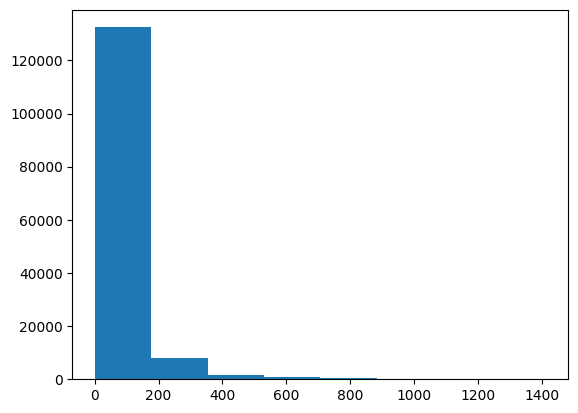

In [11]:
import matplotlib.pyplot as plt
plt.hist(comment_length, bins=8)

Sum: `max_length` for train_comment should be 230, now go for `max_vocab_length`
## 2.1.2. `max_vocab_length`

In [12]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ILLEGEAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ILLEGEAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
import nltk
from nltk.tokenize import word_tokenize

# Sample text
text = "This is a sample text for understanding max vocabulary length."

# Tokenize the text
tokens = word_tokenize(text)

# Create a vocabulary
vocabulary = set(tokens)

# Find the max vocabulary length
print("Max vocabulary length:", len(max(vocabulary, key=len)))

Max vocabulary length: 13


In [14]:
vocabulary = set(word.lower() for comment in train_comment for word in comment.split())

max_vocab_length = len(max(vocabulary, key=len))
print("Max vocabulary length:", max_vocab_length)

Max vocabulary length: 4958


## 2.2 Create Text Vectorizer

In [15]:
max_length = 230
max_vocab_length = 10000

from tensorflow.keras.layers import TextVectorization
import tensorflow as tf

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                                    standardize='lower_and_strip_punctuation',
                                                    output_sequence_length=max_length,
                                                    output_mode='int')

In [16]:
# Adapt it
text_vectorizer.adapt(train_comment)

In [17]:
import random
random_comment = random.choice(train_comment)
print(f'Original text:\n{random_comment}\
      \n\nVectorized version:')
text_vectorizer([random_comment])

Original text:
"
Good start, but most people will expect at least six months actively editing and 2,000 edits or so before considering supporting a candidate. Not that those people are me, but that's a de facto standard. — (talk) "      

Vectorized version:


<tf.Tensor: shape=(1, 230), dtype=int64, numpy=
array([[  98,  432,   27,  133,   76,   44, 1101,   34,  295, 1803,  767,
        3921,  116,    5, 2009,  123,   26,   37,  144, 1230, 1700,    6,
        2600,   15,   10,  141,   76,   20,   36,   27,  176,    6,  928,
        5236,  800,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [18]:
# How many words in our training vocabulary?
x = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(x)}"),
print(f"Most common words in the vocabulary: {x[:5]}")
print(f"Least common words in the vocabulary: {x[-5:]}")

Number of words in vocabulary: 10000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'to', 'of']
Least common words in the vocabulary: ['seeds', 'seed', 'safer', 'rw', 'rounds']


In [19]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 10000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 230,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 10000}

## 2.3 Create Embedding

In [20]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             mask_zero=True,
                             embeddings_initializer='uniform',
                             input_length=max_length,
                             name='embedding_1')
embedding

In [21]:
# Show example embedding
print(f"Sentence before vectorization:\n{random_comment}\n")
vectorized_sentence = text_vectorizer([random_comment])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
"
Good start, but most people will expect at least six months actively editing and 2,000 edits or so before considering supporting a candidate. Not that those people are me, but that's a de facto standard. — (talk) "

Sentence after vectorization (before embedding):
[[  98  432   27  133   76   44 1101   34  295 1803  767 3921  116    5
  2009  123   26   37  144 1230 1700    6 2600   15   10  141   76   20
    36   27  176    6  928 5236  800    1    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   

## 2.4 Create datasets
- `tf.data`
- PrefetchDataset, `batch(), prefetch(), tf.data.AUTOTUNE()`

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_comment, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_comment, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

# 3. Build Model

## 3.1 Baseline 1
- Simpler, Efficient, but do not provide insights for each category

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a OneVsRestClassifier with MultinomialNB as the base estimator
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(MultinomialNB()))
])

model_0.fit(train_comment, train_labels)

baseline_score = model_0.score(val_comment, val_labels)
print(f"Model 0 score: {baseline_score}")

Model 0 score: 0.8991101641809751


In [32]:
model_0_preds = model_0.predict(val_comment)
model_0_preds[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [33]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=model_0_preds)
baseline_results

c:\Users\ILLEGEAR\anaconda3\envs\py3900\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 89.91101641809752,
 'precision': 0.8798293651918689,
 'recall': 0.10532244438186426,
 'f1': 0.18522543349795792}

## 3.2 Baseline 2
- **One-vs-rest** approach allows you to analyze the performance of each category and potentially fine-tune models individually

In [ ]:
type(train_labels)

In [ ]:
import pandas as pd

# Convert train_labels back to a DataFrame
train_labels1 = pd.DataFrame(train_labels)

type(train_labels1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

models = []
# Extract category names
category_names = list(train_labels1.columns)

for i in range(len(category_names)):
    # Create a new label array with 1 for the current category and 0 for others
    new_labels = train_labels1.iloc[:, i].copy()
    new_labels[new_labels != 1] = 0  # Replace non-category values with 0

    # Create and fit the model pipeline
    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])
    model.fit(train_comment, new_labels)
    models.append(model)

# Evaluate each model using cross-validation (optional)
scores = cross_val_score(models[0], train_comment, train_labels1.iloc[:, 0], cv=5)
print(f"Model 0 (toxic) CV score: {scores.mean()}")

# Repeat for other categories and scores

## 3.3 `Model_1` USE Transfer Learning

### 3.3.1 Test USE Url

In [ ]:
import tensorflow as tf
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
sample_sentence = 'There is a flood in my street'
embed_samples = embed([sample_sentence,
                      "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

### 3.3.2 Build Embedding Layer Using USE

In [ ]:
use_embed_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                 input_shape=[],
                                 dtype=tf.string,
                                 trainable=False,
                                 name='use')

### 3.3.3 Build Model

In [ ]:
inputs = layers.Input(shape=(), dtype=tf.string)
x = use_embed_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(6, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_USE')

model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary

In [ ]:
model_1_history = model_1.fit(train_comment,
                              train_labels,
                              epochs=5,
                              validation_data=(val_comment, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name='model_logs',
                                                                     experiment_name='model_1_USE')])

In [ ]:
model_1_preds = model_1.predict(val_comment)
model_1_preds

In [ ]:
model_1_preds_label = tf.argmax(model_1_preds, axis=1)
model_1_preds_label

In [ ]:
val_labels[:5], model_1_preds_label[:5]

In [ ]:
val_labels_tf = tf.convert_to_tensor(val_labels)
val_labels_tf[:5]

In [ ]:
model_1_results = calculate_results(y_true=val_labels_tf,
                                    y_pred=model_1_preds)
model_1_results

## 3.4 `Model_2`: Conv1D with character embeddings

### 3.4.1 Split sentences to characters

In [34]:
random_comment

'"\n\n==WP Delinking Dates==\n\nCongratulations on being one of the most destuctrive forces on Wikipedia. Your campaign to delink dates ensures that scores of children won\'t be at all concerned about history. "'

In [35]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_comment)

'" \n \n = = W P   D e l i n k i n g   D a t e s = = \n \n C o n g r a t u l a t i o n s   o n   b e i n g   o n e   o f   t h e   m o s t   d e s t u c t r i v e   f o r c e s   o n   W i k i p e d i a .   Y o u r   c a m p a i g n   t o   d e l i n k   d a t e s   e n s u r e s   t h a t   s c o r e s   o f   c h i l d r e n   w o n \' t   b e   a t   a l l   c o n c e r n e d   a b o u t   h i s t o r y .   "'

### 3.4.2 Create char-lvl datasets by splitting out sequence datasets into characters

In [36]:
train_chars = [split_chars(i) for i in train_comment]
val_chars = [split_chars(i) for i in val_comment]
train_chars[0]

'" \n \n D a n i l o v i c \n A l r i g h t ,   w e \' l l   s t a y   a w a y   f r o m   v a l u e - j u d g e m e n t ,   a l t h o u g h   w h e n   y o u \' v e   g o t   a   d o c u m e n t e d   r a p   s h e e t   a s   l o n g   a s   D a n i l o v i c \' s ,   " " s u r l y " "   i s   a l m o s t   a   c o m p l i m e n t .   \n Y e s ,   B l i c   i s   a   r e l i a b l e   s o u r c e .   I t \' s   o n e   o f   t h e   h i g h - c i r c u l a t i o n   d a i l i e s   i n   S e r b i a .   Y e s ,   i t \' s   a   m i d d l e - m a r k e t   t a b l o i d ,   b u t   i t   d o e s n \' t   i n v e n t   s t o r i e s .   I t \' s   v e r y   s i m i l a r   t o   B r i t a i n \' s   D a i l y   M a i l .   P l u s   t h e   c a s e   o f   D a n i l o v i c   b e a t i n g   u p   r e f e r e e   J u r a s   i s   w e l l - d o c u m e n t e d   i n   S e r b i a n   m e d i a   a s   w e l l   a s   t h e   r e s u l t i n g   s a n c t i o n s ,   b o t h   b a s k e

In [37]:
# Check what is the avg char length
char_lens = [len(i) for i in train_chars]
output_seq_char_lens = int(np.percentile(char_lens, 95))
np.mean(char_lens), output_seq_char_lens, max(char_lens)

(787.6917201089038, 2711, 9999)

(array([113423.,  18211.,   5997.,   2362.,   1063.,    669.,    510.,
           437.,    360.,    581.]),
 array([  11. , 1009.8, 2008.6, 3007.4, 4006.2, 5005. , 6003.8, 7002.6,
        8001.4, 9000.2, 9999. ]),
 <BarContainer object of 10 artists>)

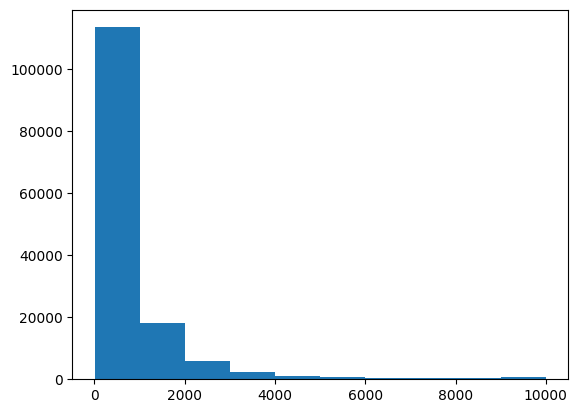

In [38]:
# Check distribution of our sequences at char-lvl
plt.hist(char_lens, bins=10)

### 3.4.3 Create Tokenization Layer

In [39]:
# Get all keyboard chars for char-lvl embeddings
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [55]:
# Create char-lvl token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # Space + OOV
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_lens,
                                    standardize='lower_and_strip_punctuation',
                                    output_mode='int',
                                    name='char_vectorizer')

In [56]:
# Adapt char vectorizer to train_chars
char_vectorizer.adapt(train_chars)

In [58]:
# Check vocab characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 Most common characters: {char_vocab[:5]}")
print(f"5 Least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 70
5 Most common characters: ['', '[UNK]', 'e', 't', 'a']
5 Least common characters: ['ı', 'α', 'т', 'ä', 'с']


In [61]:
# Test out char_vect
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized_chars: {len(vectorized_chars[0])}")

Charified text:
I d i o c r a c y   
 
 I f   y o u   n e e d   a   1 3   s e c t i o n   F A Q   t o   j u s t i f y   y o u r   i d i o c y   t h e n   i t   i s   c l e a r   y o u r   b i a s   v i e w p o i n t   i s   w r o n g ,   r e n a m e   t h e   a r t i c l e   t o   M E G A   D R I V E   a n d   s t o p   b e i n g   i d i o t s . . . . 8 2 . 4 1 . 1 0 7 . 9 7     
 
 P l e a s e   d o   n o t   r e m o v e   m y   i n p u t   a g a i n . . .   i t   v i o l a t e s   W P : P R E S E R V E   W P : V A N D A L I S M   a n d   W P : N O T C E N S O R E D   a l s o   p l e a s e   s t o p   b e i n g   i d i o t   A m e r i c a n s   a n d   o f f e n d i n g   t h e   r e s t   o f   t h e   w o r l d   w i t h   y o u r   b a c k w a r d ,   b i a s e d   a n d   d i s t o r t e d   v i e w s   w h i c h   y o u   t r y   t o   f o r c e   u p o n   i s   l i k e   t h i s   a r t i c l e s   t i t l e 8 2 . 4 1 . 1 0 7 . 9 7

Length of random_train_chars: 390

Vectorized

### 3.4.4 Char-lvl Embedding

In [50]:
tf.random.set_seed(42)
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=128,
                              embeddings_initializer='uniform',
                              input_length=output_seq_char_lens,
                              name='embedding_1')
char_embed

In [62]:
# Get a random sentence from training set
print(f"Ori: {random_comment}\
      \n\nEmbedded:")

sample_embed = char_embed(char_vectorizer([random_comment]))
sample_embed

Ori: "

==WP Delinking Dates==

Congratulations on being one of the most destuctrive forces on Wikipedia. Your campaign to delink dates ensures that scores of children won't be at all concerned about history. "      

Embedded:


<tf.Tensor: shape=(1, 2711, 128), dtype=float32, numpy=
array([[[ 0.03357713, -0.00152319, -0.02870076, ..., -0.04505892,
         -0.0170892 ,  0.04813454],
        [ 0.03357713, -0.00152319, -0.02870076, ..., -0.04505892,
         -0.0170892 ,  0.04813454],
        [ 0.03357713, -0.00152319, -0.02870076, ..., -0.04505892,
         -0.0170892 ,  0.04813454],
        ...,
        [-0.01648936,  0.03550879,  0.0495749 , ...,  0.04656985,
          0.04111593,  0.04639396],
        [-0.01648936,  0.03550879,  0.0495749 , ...,  0.04656985,
          0.04111593,  0.04639396],
        [-0.01648936,  0.03550879,  0.0495749 , ...,  0.04656985,
          0.04111593,  0.04639396]]], dtype=float32)>

### 3.4.5 Build Conv1D Model

In [64]:
inputs = layers.Input(shape=(1,), dtype='string')
x = char_embed(char_vectorizer(inputs))
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(6, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_Conv1D')

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "model_2_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 2711)              0         
 rization)                                                       
                                                                 
 embedding_1 (Embedding)     (None, 2711, 128)         8960      
                                                                 
 conv1d_1 (Conv1D)           (None, 2711, 64)          41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 6)              

Label Encoding (One Target Column)
- Use for multi-class classification
- `Dense(num_classes, activation='softmax')`
- Loss: `categorical` (For one-hot), or `sparse` (For label)

Keep Columns Separated (Multiple Binary Targets)
- Use for Multi-Label Classification
- `Dense(num_classes, activation='sigmoid')`
- Loss: `binary`|

### 3.4.6 Create char-level batched `PrefetchDataset`

In [67]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [69]:
# Fit model on chars only
model_2_history = model_2.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
448/448 [==============================] - 143s 319ms/step - loss: 0.0851 - accuracy: 0.9205 - val_loss: 0.0879 - val_accuracy: 0.8380
Epoch 2/3
448/448 [==============================] - 134s 299ms/step - loss: 0.0824 - accuracy: 0.9153 - val_loss: 0.0837 - val_accuracy: 0.8833
Epoch 3/3
448/448 [==============================] - 134s 300ms/step - loss: 0.0798 - accuracy: 0.9112 - val_loss: 0.0781 - val_accuracy: 0.8438


In [70]:
model_2_pred_probs = model_2.predict(val_char_dataset)
model_2_pred_probs

499/499 [==============================] - 26s 52ms/step


array([[0.00316704, 0.00019774, 0.00107641, 0.00064655, 0.0025386 ,
        0.00250135],
       [0.0085618 , 0.00128876, 0.00452573, 0.00378456, 0.00585344,
        0.00068364],
       [0.02433012, 0.00080226, 0.01094374, 0.00090181, 0.00935942,
        0.00699687],
       ...,
       [0.00464168, 0.00034234, 0.00628407, 0.00066191, 0.00433614,
        0.00453767],
       [0.00184888, 0.00037755, 0.00131398, 0.00038456, 0.00237037,
        0.00182727],
       [0.02075131, 0.00133719, 0.01656135, 0.00186973, 0.01031332,
        0.00529115]], dtype=float32)

In [71]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0], dtype=int64)>

## 3.5: `Model_3` GRU

### 3.5.1 Create embed and build model

In [23]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, GRU, Dense, Input
from tensorflow.keras.models import Model

tf.random.set_seed(42)

num_words = 10000
embedding_dim = 128
max_seq_len = 100
num_classes = 6

model_3_embed = Embedding(input_dim=num_words,
                                 output_dim=embedding_dim,
                                 input_length=max_seq_len,
                                 embeddings_initializer='uniform',
                                 name='embedding_GRU')

inputs = Input(shape=(1,), dtype='string')
x = model_3_embed(text_vectorizer(inputs))
x = GRU(64, return_sequences=True)(x)
x = GRU(64)(x)
outputs = Dense(num_classes, activation='sigmoid')(x)

model_3 = Model(inputs, outputs, name='model_3_GRU')
model_3.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 230)               0         
 ctorization)                                                    
                                                                 
 embedding_GRU (Embedding)   (None, 230, 128)          1280000   
                                                                 
 gru (GRU)                   (None, 230, 64)           37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                       

### 3.5.2 Take 10% of the data to train

In [24]:
train_comment_90, train_comment_10, train_labels_90, train_labels_10 = train_test_split(np.array(train_comment),
                                                                                        train_labels,
                                                                                        test_size=0.1,
                                                                                        random_state=42)

print(f"Total training examples: {len(train_comment)}")
print(f"Length of 10% training examples: {len(train_comment_10)}")

Total training examples: 143613
Length of 10% training examples: 14362


### 3.5.3 Train the model

In [25]:
model_3_history = model_3.fit(train_comment_10, train_labels_10,
                              epochs=5,
                              validation_data=(val_comment, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240912-222923
Epoch 1/5
449/449 [==============================] - 148s 319ms/step - loss: 0.1533 - accuracy: 0.9925 - val_loss: 0.1430 - val_accuracy: 0.9937
Epoch 2/5
449/449 [==============================] - 128s 284ms/step - loss: 0.1395 - accuracy: 0.9949 - val_loss: 0.1428 - val_accuracy: 0.9937
Epoch 3/5
449/449 [==============================] - 128s 286ms/step - loss: 0.1396 - accuracy: 0.9949 - val_loss: 0.1428 - val_accuracy: 0.9936
Epoch 4/5
449/449 [==============================] - 147s 328ms/step - loss: 0.1260 - accuracy: 0.9790 - val_loss: 0.0778 - val_accuracy: 0.9935
Epoch 5/5
449/449 [==============================] - 179s 398ms/step - loss: 0.0606 - accuracy: 0.9951 - val_loss: 0.0662 - val_accuracy: 0.9937


Since the GRU Model is that good, we can train on full dataset

In [84]:
model_3_full_history = model_3.fit(train_comment, train_labels,
                                   epochs=5,
                                   validation_data=(val_comment, val_labels),
                                   callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_3_GRU_full')])

Saving TensorBoard log files to: model_logs/model_3_GRU_full/20240912-140544
Epoch 1/5
4488/4488 [==============================] - 933s 208ms/step - loss: 0.0510 - accuracy: 0.9927 - val_loss: 0.0519 - val_accuracy: 0.9924
Epoch 2/5
4488/4488 [==============================] - 790s 176ms/step - loss: 0.0438 - accuracy: 0.9926 - val_loss: 0.0480 - val_accuracy: 0.9883
Epoch 3/5
4488/4488 [==============================] - 789s 176ms/step - loss: 0.0386 - accuracy: 0.9882 - val_loss: 0.0501 - val_accuracy: 0.9905
Epoch 4/5
4488/4488 [==============================] - 782s 174ms/step - loss: 0.0339 - accuracy: 0.9625 - val_loss: 0.0527 - val_accuracy: 0.8987
Epoch 5/5
4488/4488 [==============================] - 784s 175ms/step - loss: 0.0295 - accuracy: 0.9076 - val_loss: 0.0560 - val_accuracy: 0.9783


## Save Model

In [26]:
model_3.save("model_3_SavedModel_format")

INFO:tensorflow:Assets written to: model_3_SavedModel_format\assets


INFO:tensorflow:Assets written to: model_3_SavedModel_format\assets


### 4. Generate Predictions on `test_df`

### 4.1 Load Model

In [14]:
import tensorflow as tf
from tensorflow import keras
loaded_model = tf.keras.models.load_model("model_3_SavedModel_format")

In [11]:
loaded_model.evaluate(val_comment, val_labels)

499/499 [==============================] - 22s 43ms/step - loss: 0.0662 - accuracy: 0.9937


[0.06620540469884872, 0.9936708807945251]

### 4.2 Re-structure `test.csv` and `test_labels.csv` to generate predictions

#### 4.2.1 Check files top 5 samples

In [8]:
import pandas as pd
test = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

train_df = pd.read_csv('train.csv')
train_df_shuffled = train_df.sample(frac=1, random_state=42)

from sklearn.model_selection import train_test_split
train_comment, val_comment, train_labels, val_labels = train_test_split(train_df_shuffled['comment_text'].to_numpy(),
                                                                        train_df_shuffled.drop(['id', 'comment_text'], axis=1).to_numpy(),
                                                                        test_size=0.1,
                                                                        random_state=42)

In [9]:
print(f"'test.csv' file: {test[:2]}")
print(f"\n'test_labels.csv' file: {test_labels[:2]}")
print(f"\n'val_comment' dataframe: {val_comment[:2]}")
print(f"\n'val_labels' dataframe: {val_labels[:2]}")

'test.csv' file:                  id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...

'test_labels.csv' file:                  id  toxic  severe_toxic  obscene  threat  insult  \
0  00001cee341fdb12     -1            -1       -1      -1      -1   
1  0000247867823ef7     -1            -1       -1      -1      -1   

   identity_hate  
0             -1  
1             -1  

'val_comment' dataframe: ['September 2006\nThank you for experimenting with the page Construction on Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.'
 "Thank you. I'm on the link-deletion now."]

'val_labels' dataframe: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]]


#### 4.2.2 Make sure `test` & `test_labels` are in the same format as `val_comment` and `val_labels`

In [13]:
# Filter out rows with invalid labels (-1 in any column) from `test_labels`
test_labels_clean = test_labels[test_labels.iloc[:, 1:].min(axis=1) != -1]

# Merge test with test_labels_clean on `id` to ensure alignment
test_clean = pd.merge(test, test_labels_clean, on='id')

# Extract test comments (equivalent to val_comment)
test_comment = test_clean['comment_text'].to_numpy()

# Extract test labels (same as val_labels) and drop cols 'id' and other
test_labels_final = test_clean.drop(['id', 'comment_text'], axis=1).to_numpy()

# Check output
print(f"'test_comment' array: {test_comment[:2]}")
print(f"\n'test_labels_final' array: {test_labels_final[:2]}")
print(f"\n'val_comment' dataframe: {val_comment[:2]}")
print(f"\n'val_labels' dataframe: {val_labels[:2]}")


'test_comment' array: ['Thank you for understanding. I think very highly of you and would not revert without discussion.'
 ':Dear god this site is horrible.']

'test_labels_final' array: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]]

'val_comment' dataframe: ['September 2006\nThank you for experimenting with the page Construction on Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.'
 "Thank you. I'm on the link-deletion now."]

'val_labels' dataframe: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]]


### 4.3 Generate Predictions on test files

In [15]:
loaded_model.evaluate(test_comment, test_labels_final)

2000/2000 [==============================] - 111s 55ms/step - loss: 0.0758 - accuracy: 0.9976


[0.07576501369476318, 0.9975929260253906]

In [16]:
test_predictions_prob = loaded_model.predict(test_comment)

test_predictions = (test_predictions_prob > 0.5).astype(int)

2000/2000 [==============================] - 86s 42ms/step


In [17]:
print(test_predictions[:5])

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


### 4.4 Print Classification Report

In [25]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_final, test_predictions))

              precision    recall  f1-score   support

           0       0.70      0.61      0.65      6090
           1       0.41      0.08      0.13       367
           2       0.75      0.55      0.64      3691
           3       0.00      0.00      0.00       211
           4       0.66      0.47      0.55      3427
           5       0.00      0.00      0.00       712

   micro avg       0.70      0.51      0.59     14498
   macro avg       0.42      0.29      0.33     14498
weighted avg       0.65      0.51      0.57     14498
 samples avg       0.05      0.05      0.05     14498



c:\Users\ILLEGEAR\anaconda3\envs\py3900\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ILLEGEAR\anaconda3\envs\py3900\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ILLEGEAR\anaconda3\envs\py3900\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\

### 4.5 Save into `submission.csv`

In [23]:
test_predictions.shape

(63978, 6)

In [26]:
# Convert predictions to a DataFrame with appropriate column names
test_predictions_df = pd.DataFrame(
    test_predictions, 
    columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
)

# Combine the 'id' column from the test DataFrame with the predictions DataFrame
submission_df = pd.concat([test['id'], test_predictions_df], axis=1)

In [27]:
# Save the DataFrame to CSV
submission_df.to_csv('predictions.csv', index=False)